In [1]:
#Developed by Faraz S. Tehrani
#Deltares, 2020

In [2]:
# pip install joblib

In [65]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

# from sklearn.externals import joblib
import joblib

In [66]:
def evaluateTrainedModel(model, X_eval, y_eval):
  predictions = model.predict(X_eval)
  accuracy = accuracy_score(y_eval, predictions)
  other_metrics = precision_recall_fscore_support(y_eval, predictions)
  precision = other_metrics[0][0]
  recall = other_metrics[1][0]
  f1_score= other_metrics[2][0]
  confusion = pd.DataFrame(confusion_matrix(y_eval, predictions))
  print('Confusion matrix = \n', confusion)
  return accuracy, precision, recall, f1_score


def saveMLModel(model, path, fileName):  
  joblib.dump(model, path+fileName) #.sav extension

def loadMLModel(path, modelName):
  return joblib.load(path+modelName)

In [67]:
#read files from google drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
pathToFolder = "/content/drive/My Drive/LandslideDetection/"
df = pd.read_csv(pathToFolder+'df4ML.csv')

In [69]:
df.head()

,segment_id,area_m2,east,north,b4,b3,b2,b8,ndvi,ndvi_change,ratio_rg_change,brightness,brightness_change,gndvi,slope_max,slope_mean,nd_std,height_mean,height_min,height_max,Type
0,L0_S1,17900.0,312661.201117,131768.016760,546.782123,897.173184,944.201117,3058.553073,0.693484,0.075303,0.534168,0.796052,-0.143795,0.542556,43.198013,27.588178,0.051713,1266.162011,1191.0,1329.0,0.0
1,L0_S12,54800.0,314277.390511,131602.755474,590.445255,930.883212,959.585766,3077.003650,0.677110,-0.128013,0.270799,0.826971,-0.005416,0.534582,26.351656,13.395944,0.026207,1038.985401,1004.0,1078.0,0.0
2,L0_S210,16400.0,315188.597561,131301.219512,806.646341,1082.579268,1086.628049,2972.048780,0.569681,0.030250,0.510916,0.991951,-0.205500,0.461150,36.183422,14.654994,0.118956,807.823171,791.0,873.0,0.0
3,L0_S223,8200.0,315548.414634,131315.731707,1116.804878,1219.817073,1228.756098,2597.500000,0.399993,-0.056752,0.414258,1.188459,-0.096933,0.357630,10.729084,6.369848,0.116028,748.000000,739.0,754.0,0.0
4,L0_S308,400.0,314450.000000,131170.000000,846.750000,1122.000000,1082.000000,3610.000000,0.620022,0.137240,0.638781,1.016917,-0.292388,0.525468,31.465822,31.465822,0.044013,1017.000000,1017.0,1017.0,0.0


In [70]:
df['Landslide_Region']=df['segment_id'].apply(lambda x: x.split('_')[0])

In [71]:
df.columns

Index(['segment_id', 'area_m2', 'east', 'north', 'b4', 'b3', 'b2', 'b8',
       'ndvi', 'ndvi_change', 'ratio_rg_change', 'brightness',
       'brightness_change', 'gndvi', 'slope_max', 'slope_mean', 'nd_std',
       'height_mean', 'height_min', 'height_max', 'Type', 'Landslide_Region'],
      dtype='object')

In [72]:
#rename columns
df = df.rename(columns={'ndvi':'NDVI', 'ndvi_change':'VDI', 'ratio_rg_change':'RGD', 'brightness':'BR',
       'brightness_change':'BRD', 'gndvi':'GNDVI', 'nd_std':'NDVI_std','b4':'B4', 'b3':'B3', 'b2':'B2', 'b8':'B8'})
df = df[['segment_id', 'Landslide_Region','area_m2', 'east', 'north',
         'B2','B3','B4','B8','NDVI','NDVI_std','GNDVI','VDI','BR', 'BRD',
         'height_mean', 'height_min', 'height_max','slope_max', 'slope_mean',
         'Type']]

In [73]:
df_train = df[(df['Landslide_Region']!='L0') & (df['Landslide_Region']!='L1') & (df['Landslide_Region']!='L2') & (df['Landslide_Region']!='L15')]
df_test = df[(df['Landslide_Region']=='L0') | (df['Landslide_Region']=='L1') | (df['Landslide_Region']=='L2') | (df['Landslide_Region']=='L15')]

In [35]:
len(df_train)

343

In [36]:
len(df_test)

122

In [74]:
feat2=['B8', 'NDVI', 'NDVI_std', 'VDI', 'BR', 'BRD', 'height_mean', 'slope_max']

## **Model based on feat2**

**Split**

In [53]:
# Split and Scale the data

X_train = df_train[feat2]
y_train = df_train['Type']

X_test = df_test[feat2]
y_test = df_test['Type']

scaler2 = StandardScaler()
scaler2.fit(X_train)
X_train = scaler2.transform(X_train)
X_test = scaler2.transform(X_test)
y_train = y_train
y_test = y_test

random_state = 110

In [54]:
len(df_train)

343

In [55]:
#Random forest classifier
# define the baseline model
baselineModel = RandomForestClassifier(random_state=random_state)        

**Hyper-parameters tunning**

In [56]:
# Hyper-parameters
#RF
model_parameters_RF = {
    'bootstrap': [True],
    'max_depth': [10, 20, 50, 100, 500],
    'max_features': [2],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10, 50, 100, 200, 500, 1000]
}
#Cross-Validation
# Instantiate the grid search model
model_parameters=model_parameters_RF
grid_search = GridSearchCV(estimator=baselineModel, param_grid=model_parameters,
                           cv=5, n_jobs=4, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
print ('best model parameters: \n', grid_search.best_params_)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  3.0min
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  8.5min
[Parallel(n_jobs=4)]: Done 1792 tasks      | elapsed: 12.3min


best model parameters: 
 {'bootstrap': True, 'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 10}


[Parallel(n_jobs=4)]: Done 2250 out of 2250 | elapsed: 15.5min finished


**Evaulate the model**

In [57]:
#Evaluate the best model
best_model2 = grid_search.best_estimator_
print ('\n**Train set**')
accuracy, precision, recall, f1_score = evaluateTrainedModel(best_model2, X_train, y_train)
print('best model on train set: \n accuracy = {:6.2f},\n precision = {:6.2f},\n recall = {:6.2f},\n f1_score = {:6.2f} '.format(accuracy, precision, recall, f1_score ))

print ('\n**Test set**')
accuracy, precision, recall, f1_score = evaluateTrainedModel(best_model2, X_test, y_test)
print('best model on test set: \n accuracy = {:6.2f},\n precision = {:6.2f},\n recall = {:6.2f},\n f1_score = {:6.2f} '.format(accuracy, precision, recall, f1_score ))       


**Train set**
Confusion matrix = 
      0    1
0  204    0
1    4  135
best model on train set: 
 accuracy =   0.99,
 precision =   0.98,
 recall =   1.00,
 f1_score =   0.99 

**Test set**
Confusion matrix = 
     0   1
0  66  10
1   7  39
best model on test set: 
 accuracy =   0.86,
 precision =   0.90,
 recall =   0.87,
 f1_score =   0.89 


**feature importance**

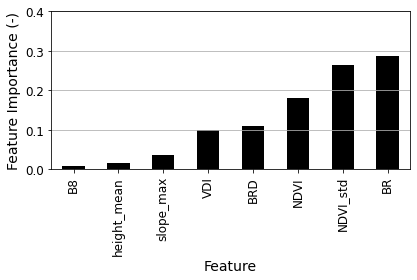

In [59]:
feats = {} # a dict to hold feature_name: feature_importance

for feature, importance in zip(df_train[feat2].columns, best_model2.feature_importances_ ):
    feats[feature] = importance #add the name/value pair 
    
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'feature importance'})

importances.sort_values(by='feature importance').plot(kind='bar',rot=90, color='black', legend= False, fontsize= 12,align="center")

plt.xlabel('Feature',size=14)
plt.ylabel('Feature Importance (-)',size=14)
plt.ylim((0,0.4))
plt.gca().yaxis.grid(True, which='major') 
plt.tight_layout()
plt.savefig(pathToFolder+'featImportance_model2-2.png',dpi=600)

**save model**

In [60]:
model_name = 'RF_model2-2.sav'
saveMLModel(best_model2,pathToFolder,model_name)

**load model**

In [61]:
model_name = 'RF_model2-2.sav'
model = loadMLModel(pathToFolder,model_name)

In [62]:
#check
accuracy, precision, recall, f1_score = evaluateTrainedModel(model, X_test, y_test)
print('model 1-2 on test set: \n accuracy = {:6.2f},\n precision = {:6.2f},\n recall = {:6.2f},\n f1_score = {:6.2f} '.format(accuracy, precision, recall, f1_score )) 

Confusion matrix = 
     0   1
0  66  10
1   7  39
model 1-2 on test set: 
 accuracy =   0.86,
 precision =   0.90,
 recall =   0.87,
 f1_score =   0.89 
